**1. PROBLEM STATEMENT**  

This project involves building a deep learning model using CNN to classify small pathological images for the presence if tumor tissue. The images are provided in patches, the goal is to predict whether the center 32x32 pixel region of each patch contains tumor cells. The outer region of the patch does not influence the label but this is included to support full convolutional models.

The training set consists of 2 fields 'id' and 'label'. The dataset has 220,025 ids, of which 130,908 are non tumor and 89,117 are tumor tissues. The test dataset has 57458 ids for which label has to be predicted.  

**Import Libraries and Load Data**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import random
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
labels = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')
train_folder = '/kaggle/input/histopathologic-cancer-detection/train'
test_folder = '/kaggle/input/histopathologic-cancer-detection/test'
print(labels['label'].value_counts())

label
0    130908
1     89117
Name: count, dtype: int64


**2. EDA**

To improve the performance, we will perform training on a sample of the original training dataset. Since the dataset might be imbalanced, we perform balanced sampling to ensure an equal number of tumor and non-tumor images for training, which helps improve model generalization. The sample will contain 18000 non-tumor and 18000 tumor images.

In [3]:
#Seperate classes
class_0 = labels[labels['label']==0]
class_1 = labels[labels['label']==1]

#Sample 8000 images from each class to get a balanced dataset.
sampled_class_0 = class_0.sample(18000,random_state=42)
sampled_class_1 = class_1.sample(18000,random_state=42)

#Combine the sampled classes to get a balanced dataset
sampled_labels = pd.concat([sampled_class_0,sampled_class_1])

#Shuffke dataset to avoid order bias
sampled_labels = sampled_labels.sample(frac=1,random_state = 42).reset_index(drop = True)


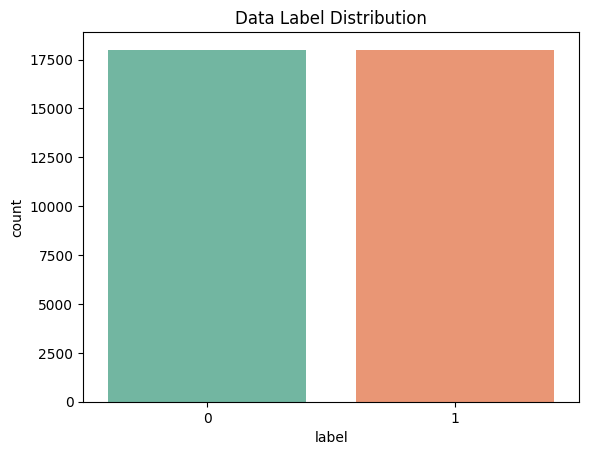

In [4]:
sns.countplot(x='label', data = sampled_labels, palette='Set2')
plt.title('Data Label Distribution')
plt.show()

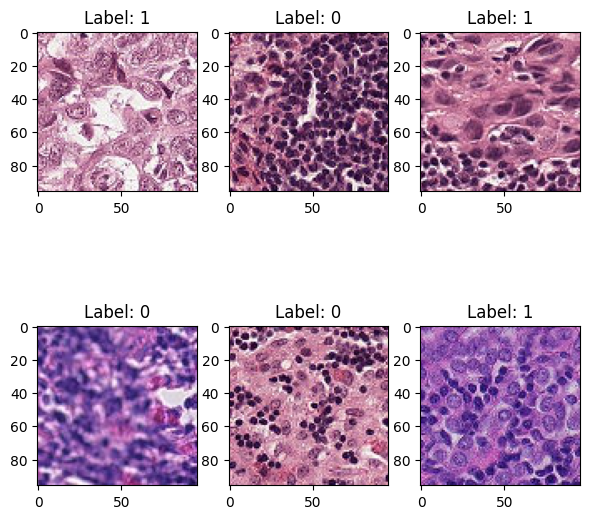

In [7]:
#Display sample images with and without tumor tissue
sample_ids = sampled_labels.sample(6)['id'].values
plt.figure(figsize=(7,7))

for i, img_id in enumerate(sample_ids):
    img = cv2.imread(os.path.join(train_folder, img_id+'.tif'))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(2,3,i+1)
    plt.imshow(img)
    plt.title(f'Label: {sampled_labels[sampled_labels.id == img_id]["label"].values[0]}')
    
plt.show()

In [8]:
#Check image sizes and statistics
sample_img = cv2.imread(os.path.join(train_folder,sampled_labels['id'][0] + '.tif'))
print(f'Image Size : {sample_img.shape}')

Image Size : (96, 96, 3)


Next we will resize the images to 32x32, focusing only on the center region as this is where the tumor tissues is checked for.

In [9]:
def load_process_images(img_folder, labels=None):
    img_data = []
    img_labels = []
    
    for idx, row in labels.iterrows():
        img_id = row['id']
        label = row['label']
        #File path for each image 
        img_path = os.path.join(img_folder, img_id + '.tif')
        
        if not os.path.exists(img_path):
            continue
        
        #Load Image
        img = cv2.imread(img_path)
        if img is None:
            continue
            
        #Crop to the center 32x32 region
        img_center = img[32:64, 32:64, :]
        
        img_data.append(img_center)
        img_labels.append(label)
                    
    img_data = np.array(img_data)
    img_labels = np.array(img_labels)
    return img_data, img_labels

In [10]:
# Load training images and labels
train_images, train_labels = load_process_images(train_folder, sampled_labels)
#Normalize image data
train_images = train_images/255.0
X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.2,
                                                 random_state=42)

Next we split the dataset to training & validation set.

In [11]:
print(f'Training data shape : {X_train.shape}')
print(f'Validation data shape : {X_val.shape}')

Training data shape : (28800, 32, 32, 3)
Validation data shape : (7200, 32, 32, 3)


**3. Model Architecture**

We will build a CNN for this task. The architecture will use convolutional layers for feature extraction and fully connected layers for classification. Two architectures are compared - a standard CNN and a deeper version- to find the most suitable for the task.

First we will design a simple model.

This architecture was constructed after the below considerations :

* Convolution Layers : Automatically extract features like edges, textures, etc.
* Max Pooling : Reduces dimensionality and computation, helping the network focus on import features
* Dropout : Reduces overfitting by randomly setting some activations to 0 during training
* Sigmoid Activation : Provides a binary output (0 or 1) for classification.

In [12]:
model = Sequential([Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(32,32,3)),
                   MaxPooling2D(pool_size=(2,2)),
                   Conv2D(64, kernel_size=(3,3), activation = 'relu'),
                   MaxPooling2D(pool_size=(2,2)),
                   Flatten(),
                   Dense(128, activation='relu'),
                   Dropout(0.5),
                   Dense(1, activation='sigmoid')
                   ])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 314,561 (1.20 MB)

 Trainable params: 314,561 (1.20 MB)

 Non-trainable params: 0 (0.00 B)

Now let us design a deeper architecture that has more layers. The deeper model adds mpre convolutional and dense layers, which allows it to learn more complex and detailed features from the images. With more layers, the model can understand finer details, but also becomed more computationally expensive and prone to overfitting.

In [13]:
deep_model = Sequential([Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(32,32,3)),
                   MaxPooling2D(pool_size=(2,2)),
                   Conv2D(64, kernel_size=(3,3), activation = 'relu'),
                   MaxPooling2D(pool_size=(2,2)),
                   Conv2D(128, kernel_size=(3,3),activation = 'relu'),
                   MaxPooling2D(pool_size=(2,2)),
                   Flatten(),
                   Dense(256, activation='relu'),
                   Dropout(0.5),
                   Dense(1, activation='sigmoid')
                   ])

deep_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

deep_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 224,833 (878.25 KB)

 Trainable params: 224,833 (878.25 KB)

 Non-trainable params: 0 (0.00 B)

**4. Training , Results and Analysis**

We will train both the model architectures using the same dataset and training configurations and compare performance.

In [15]:
model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['accuracy'])

Epoch 1/7
900/900 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - accuracy: 0.7104 - loss: 0.5749 - val_accuracy: 0.7564 - val_loss: 0.5161
Epoch 2/7
900/900 ━━━━━━━━━━━━━━━━━━━━ 40s 21ms/step - accuracy: 0.7602 - loss: 0.5114 - val_accuracy: 0.7563 - val_loss: 0.5130
Epoch 3/7
900/900 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - accuracy: 0.7643 - loss: 0.5035 - val_accuracy: 0.7632 - val_loss: 0.4939
Epoch 4/7
900/900 ━━━━━━━━━━━━━━━━━━━━ 19s 21ms/step - accuracy: 0.7698 - loss: 0.4950 - val_accuracy: 0.7606 - val_loss: 0.5016
Epoch 5/7
900/900 ━━━━━━━━━━━━━━━━━━━━ 19s 22ms/step - accuracy: 0.7848 - loss: 0.4721 - val_accuracy: 0.7604 - val_loss: 0.4971
Epoch 6/7
900/900 ━━━━━━━━━━━━━━━━━━━━ 19s 21ms/step - accuracy: 0.7871 - loss: 0.4691 - val_accuracy: 0.7703 - val_loss: 0.4775
Epoch 7/7
900/900 ━━━━━━━━━━━━━━━━━━━━ 19s 21ms/step - accuracy: 0.7939 - loss: 0.4587 - val_accuracy: 0.7747 - val_loss: 0.4796


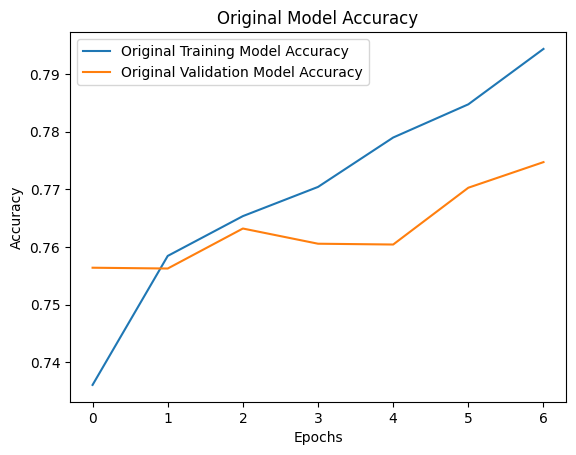

In [16]:
model_trained = model.fit(X_train,y_train, validation_data=(X_val, y_val),
                           epochs=7, batch_size=32)

# Plot training and validation accuracy for original model
plt.plot(model_trained.history['accuracy'], label = 'Original Training Model Accuracy')
plt.plot(model_trained.history['val_accuracy'], label = 'Original Validation Model Accuracy')
plt.title('Original Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


The model performance is satisfactory as minimal gap is observed between training & validation accuracy. The training model starts with an accuracy of 0.7104 and at the end of the 7th epoch, has an accuracy of 0.7939. The validation model starts with an accuracy of 0.7564 and at the end of 7th epoch, has an accuracy of 0.7747.

Now let us train the deep model and compare performance

In [17]:
deep_model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['accuracy'])

Epoch 1/7
900/900 ━━━━━━━━━━━━━━━━━━━━ 23s 24ms/step - accuracy: 0.6639 - loss: 0.6044 - val_accuracy: 0.7206 - val_loss: 0.5687
Epoch 2/7
900/900 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - accuracy: 0.7490 - loss: 0.5260 - val_accuracy: 0.7554 - val_loss: 0.5115
Epoch 3/7
900/900 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.7674 - loss: 0.4997 - val_accuracy: 0.7521 - val_loss: 0.5129
Epoch 4/7
900/900 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - accuracy: 0.7677 - loss: 0.4949 - val_accuracy: 0.7608 - val_loss: 0.5011
Epoch 5/7
900/900 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.7791 - loss: 0.4802 - val_accuracy: 0.7588 - val_loss: 0.5157
Epoch 6/7
900/900 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.7870 - loss: 0.4663 - val_accuracy: 0.7701 - val_loss: 0.4821
Epoch 7/7
900/900 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - accuracy: 0.7966 - loss: 0.4452 - val_accuracy: 0.7643 - val_loss: 0.4956


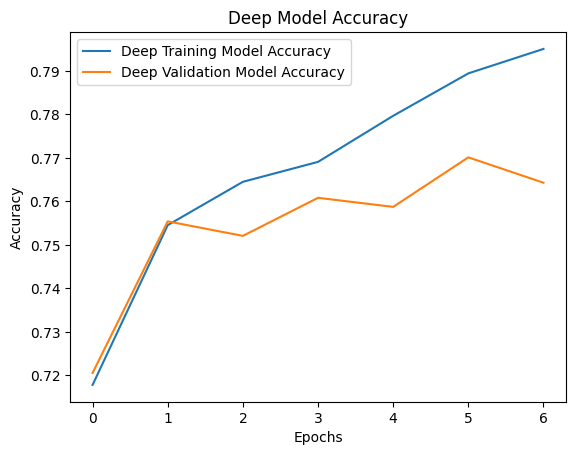

In [18]:
deep_model_trained = deep_model.fit(X_train,y_train, validation_data=(X_val, y_val),
                           epochs=7, batch_size=32)

# Plot training and validation accuracy for deep model
plt.plot(deep_model_trained.history['accuracy'], label = 'Deep Training Model Accuracy')
plt.plot(deep_model_trained.history['val_accuracy'], label = 'Deep Validation Model Accuracy')
plt.title('Deep Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


The model performance is satisfactory as minimal gap is observed between training & validation accuracy. The training model starts with an accuracy of 0.6639 and at the end of the 7th epoch, has an accuracy of 0.7966. The validation model starts with an accuracy of 0.7206 and at the end of 7th epoch, has an accuracy of 0.7643.

Now we will compare the confusion matrices for both models.

225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


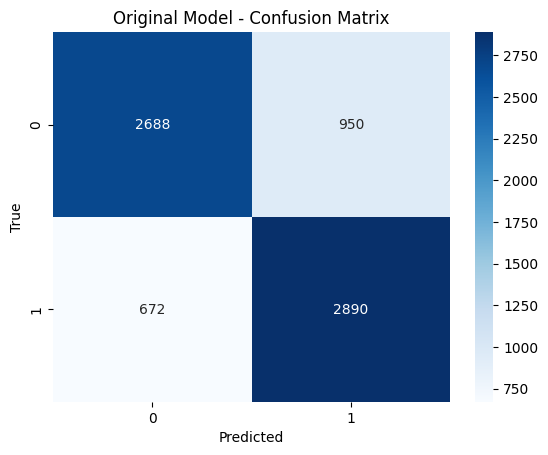

In [19]:
y_pred_original = (model.predict(X_val) > 0.5).astype("int32")
original_cm = confusion_matrix(y_val,y_pred_original)
sns.heatmap(original_cm, annot=True, fmt="d",cmap="Blues")
plt.title("Original Model - Confusion Matrix")
plt.ylabel("True")
plt.xlabel("Predicted")
plt.show()

225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step


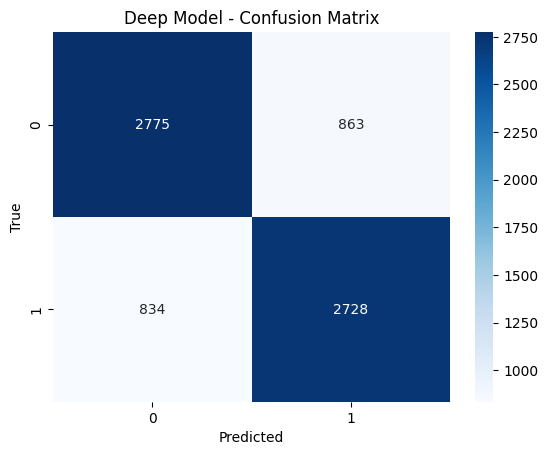

In [20]:
y_pred_deep = (deep_model.predict(X_val) > 0.5).astype("int32")
deep_cm = confusion_matrix(y_val,y_pred_deep)
sns.heatmap(deep_cm, annot=True, fmt="d",cmap="Blues")
plt.title("Deep Model - Confusion Matrix")
plt.ylabel("True")
plt.xlabel("Predicted")
plt.show()

From the above accuracy and confusion matrix analysis of both the model, we can conclude that even though the validation accuracy for both the models are comparable, the deep model has higher false negatives than the original model. Since false negatives are critical issues for tumor tissue detection, we will proceed with the original model which has fewer false negatives than deep model.

**Manual Hyperparameter Tuning**

From the original model accuracy graph, we had epochs set at 7 and batch size set at 32. Now let us try adjusting these parameters and also the learning rate and see how the model performs with these changes.

Epoch 1/10
779/779 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.7958 - loss: 0.4469 - val_accuracy: 0.7517 - val_loss: 0.5203
Epoch 2/10
779/779 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.8067 - loss: 0.4320 - val_accuracy: 0.7246 - val_loss: 0.5760
Epoch 3/10
779/779 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.8122 - loss: 0.4213 - val_accuracy: 0.7685 - val_loss: 0.5000
Epoch 4/10
779/779 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.8260 - loss: 0.3958 - val_accuracy: 0.7703 - val_loss: 0.4910
Epoch 5/10
779/779 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.8352 - loss: 0.3801 - val_accuracy: 0.7642 - val_loss: 0.5035
Epoch 6/10
779/779 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.8402 - loss: 0.3651 - val_accuracy: 0.7678 - val_loss: 0.5238
Epoch 7/10
779/779 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.8547 - loss: 0.3476 - val_accuracy: 0.7651 - val_loss: 0.5565
Epoch 8/10
779/779 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.8579 - loss: 0.3325 - 

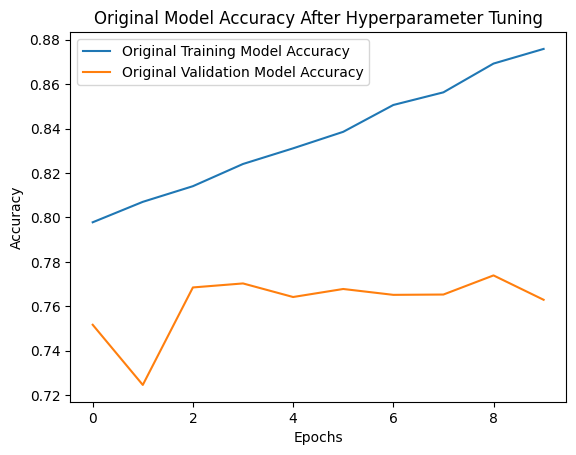

In [21]:
model_trained_tune1 = model.fit(X_train,y_train, validation_data=(X_val, y_val),
                           epochs=10, batch_size=37)

# Plot training and validation accuracy for original model
plt.plot(model_trained_tune1.history['accuracy'], label = 'Original Training Model Accuracy')
plt.plot(model_trained_tune1.history['val_accuracy'], label = 'Original Validation Model Accuracy')
plt.title('Original Model Accuracy After Hyperparameter Tuning')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


Seems to be overfitting. Continue with original epochs & batch size

**Predict test data labels**

In [22]:
def load_and_process_test_images(img_folder):
    img_data = []
    img_ids = []
    
    for img_file in os.listdir(img_folder):
        img_id = img_file.split('.')[0]
         
        #Load Image
        img_path = os.path.join(img_folder, img_file)
        img = cv2.imread(img_path)
        if img is None:
            continue
            
        #Crop to the center 32x32 region
        img_center = img[32:64, 32:64, :]
        
        img_data.append(img_center)
        img_ids.append(img_id)
                    
    img_data = np.array(img_data)
    return img_data, img_ids

In [23]:
test_images, test_ids = load_and_process_test_images(test_folder)
print(f'Test Images Loaded : {len(test_images)}')

Test Images Loaded : 57458


In [24]:
predictions = model.predict(test_images)
predicted_labels = (predictions > 0.5).astype("int32")

1796/1796 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step


In [25]:
output = pd.DataFrame({'id':test_ids, 'label':predicted_labels.flatten()})
output.to_csv('submission.csv', index=False)
print('Submission File Saved')

Submission File Saved


**5. CONCLUSION**

In this project, we developed CNNs to classify pathological images for tumor tissue. The AUC score of 0.4993 indicates that the model performed close to random guessing, highlighting issues with generalization on the test data.  

**Key Takeaways**

* Preprocessing : Focussing on center 32x32 worked, but feature extraction was likely insufficient
* Balanced Sampling : Helped prevent bias, but overall model performance remained poor
* Model Complexity : More complex models may have helped to distinguish meaningful features in the images

**Improvements For Future**

* Advanced Arcitecture : Try models like ResNet or EfficientNet for better feture extraction
* Data Augmentation : Introduce flips & rotations to enhance generalization
* Hyperparameter Tuning : Further optimize learning rate, optimizers and batch size

While results we not exactly not as expected, the project provided useful insights for future improvements.